In [1]:
import os
import infinitymonkey_os as IM_os
import json
import math
import numpy as np
import requests
import pathlib
from io import BytesIO
#import pillow
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import infinitymonkey_plot as IM_plt
#
from serval_toolkit.camera import Camera
#from tpx3 import *
import timepix3

## In cmd.exe navigate to serval folder and execute command java -jar serval-3.0.0.jar to connect the detector to the PC 

there should be a copy on the desktop as well

command line help: 1) go to parent folder "cd .." 2) go to "folder": "cd folder"

java -jar serval-3.0.0.jar

if error:
* java.io.IOException: Failed to bind to 0.0.0.0/0.0.0.0:8080

then:
* run netstat -a -n -o, find PID using port 8080, end that task (task manger [details tab])

if error: 
* Attempting reconnect...
* ERROR  Connection to /127.0.0.10:50000 failed
* WARN   Failed to reconnect to detector: Connection refused: no further information

then:
* restart (turn off, switch back on) the TimePix itself

## Test: acquire images into memory

In [2]:
c = Camera() # initalize camera object
c.connect('localhost:8080') # start connection

Connected to Serval version 3.0.0
Connected to Tpx3 camera.


select and upload configuration files (`.bpc` and `.dacs` files) using `set_chip_config_files` to manage the configuration of the chip readout

In [3]:
bpc_file_path = 'pix-config.bpc'
dacs_file_path = 'pix-config.bpc.dacs'
c.set_chip_config_files(bpc_file_path = bpc_file_path,
                        dacs_file_path = dacs_file_path)

test image acquisition (easier but slower ways)

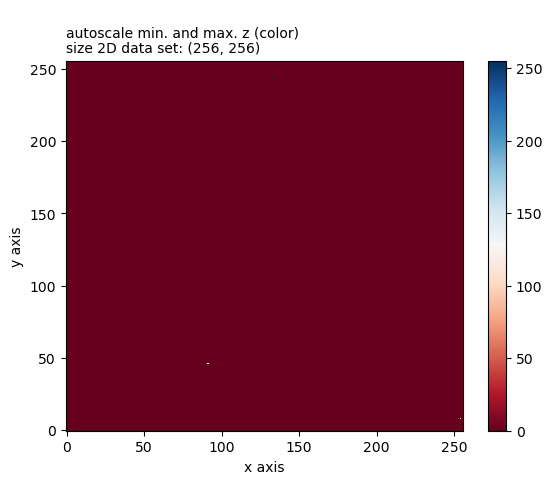

In [4]:
# single (s) or multiple (m) images
# AROUND EVERY OTHER IMAGE PRODUCES AN ERROR
sORm = 's' 
#
if sORm == 's':
    t_exp = 1
    t_trigger = 1.5*t_exp
    if t_exp < 2E-3: t_trigger = 0.002
    image = c.get_image(TriggerMode = 'AUTOTRIGSTART_TIMERSTOP',
                        ExposureTime = t_exp,
                        TriggerPeriod = t_trigger)
    IM_plt.plot_2D(image)
    
elif sORm == 'm':
    images = c.get_images(ImageFormat = 'array',
                          nTriggers=20,
                          ExposureTime = 0.1,
                          TriggerPeriod = 0.2)
    IM_plt.plot_grid(images, columns=3, fig_width=16)

The detector configuration can be read and set using the class attribute detector_config (redirects to /detector/config in the HTTP API)

In [5]:
c.detector_config # view detector configuration
#c.config # full configuration (without "PixelConfig" string [long])
#c.config_full # full configuration (with "PixelConfig")

{'Fan1PWM': 70,
 'Fan2PWM': 50,
 'BiasVoltage': 13,
 'BiasEnabled': True,
 'ChainMode': 'NONE',
 'TriggerIn': 0,
 'TriggerOut': 0,
 'Polarity': 'Positive',
 'TriggerMode': 'AUTOTRIGSTART_TIMERSTOP',
 'ExposureTime': 1.0,
 'TriggerPeriod': 1.5,
 'nTriggers': 1,
 'PeriphClk80': False,
 'TriggerDelay': 0.0,
 'Tdc': ['PN0123', 'PN0123'],
 'GlobalTimestampInterval': 0.0,
 'ExternalReferenceClock': False,
 'LogLevel': 1}

In [6]:
# `set_detector_config` sets the parameters of `detector_config`
c.set_detector_config(TriggerMode = 'AUTOTRIGSTART_TIMERSTOP',
                      ExposureTime = 1.,
                      TriggerPeriod = 1.5)

## Full functionality: i) configure detector and data output ii) acquire via `measurement_start` [lowest latency] 

RAW data format contains the time and time-over-threshold information of each registered hit, as well as the TDC events (`.tpx3` format)

In [7]:
tpx3 = timepix3.TRAPXPStpx3()
tpx3.start_session()

Server URL: http://localhost:8080
connection (expected is "200"): Welcome to Serval, the HTTP API to control and receive data from Amsterdam Scientific Instruments cameras.

Version:
Software Version: 3.0.0
Software Timestamp: 2022/06/21 14:04
Software Commit: 60be309
Software Build: 311

Information:
GET /dashboard (gets general readily available information)
GET /server (gets server information)
GET /measurement (gets measurement information)
GET /detector (gets detector information)
GET /* (gets the full JSON tree)

An example session:
GET /detector/connect (connects to a detector)
PUT /server/destination (uploads a JSON with destination info)
PUT /detector/config (uploads a JSON with the detector configuration)
GET /measurement/start (starts a measurement)
GET /measurement/stop (stops a measurement)
GET /detector/disconnect (disconnects from a detector)
GET /server/shutdown (shuts down the server)

And many more. Please refer to the manual.



dashboard:
 {'Server': {'SoftwareCommi

In [8]:
path_data = os.path.join(os.getcwd(), 'data/2024-04-18')
tpx3.set_TR_path(path = path_data)
#tpx3.test_TR_acq()

In [40]:
tpx3.init_acquisition(trigger_mode = "AUTOTRIGSTART_TIMERSTOP",
                      ntriggers = 720,
                      trigger_period = 10,
                      exposure_time = 9.5)

Response of updating Detector Configuration: Successfully uploaded detector config.



In [41]:
tpx3.get_detector_config()

Detector Configuration from SERVAL : {
  "Fan1PWM" : 70,
  "Fan2PWM" : 50,
  "BiasVoltage" : 30,
  "BiasEnabled" : true,
  "ChainMode" : "NONE",
  "TriggerIn" : 0,
  "TriggerOut" : 0,
  "Polarity" : "Positive",
  "TriggerMode" : "AUTOTRIGSTART_TIMERSTOP",
  "ExposureTime" : 9.5,
  "TriggerPeriod" : 10.0,
  "nTriggers" : 720,
  "PeriphClk80" : false,
  "TriggerDelay" : 0.0,
  "Tdc" : [ "PN0123", "PN0123" ],
  "GlobalTimestampInterval" : 0.0,
  "ExternalReferenceClock" : false,
  "LogLevel" : 1
}



In [42]:
tpx3.set_TR_file(file_number = 44, mode="count", int_size=0) # set file number
tpx3.acquisition_test() # acquire data

Response of uploading the Destination Configuration to SERVAL : Successfully uploaded destination configuration.

Response of acquisition start: Successfully started measurement.



ConnectionError: HTTPConnectionPool(host='localhost', port=8080): Max retries exceeded with url: /dashboard (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000022C386D2150>: Failed to establish a new connection: [WinError 10048] Only one usage of each socket address (protocol/network address/port) is normally permitted'))

Found 720 files starting with 0044 and ending in .tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


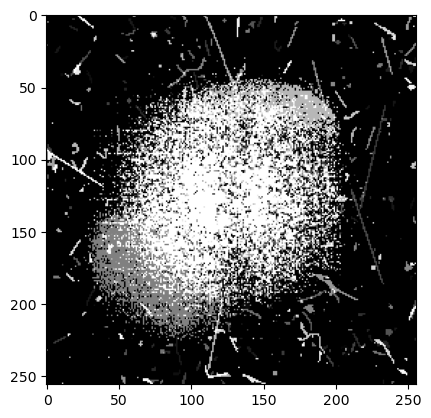

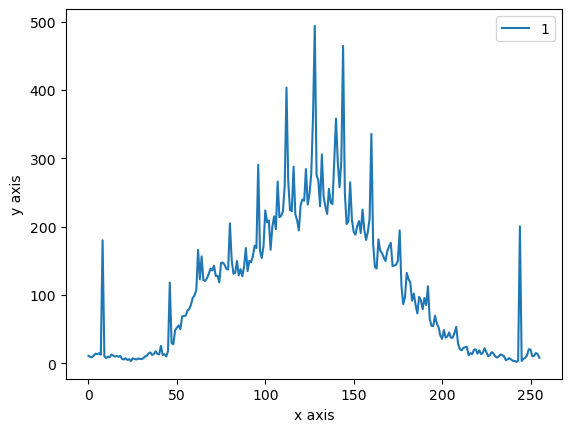

average (per trigger) counts: 28281.470833333333


In [43]:
[img_avg, spectrum, counts] = tpx3_sum_all(path_data, file_number = 44)
print(f'average (per trigger) counts: {counts}')

In [9]:
#
def tpx3_sum_all(path_data, file_number):
    """
    """
    files = find_files(path = path_data +'\\img',
                       file_type = 'tiff',
                       search_str = str('%04d'%file_number), # str(self.DA_fmt%file_number),
                       show_info = 0)
    # sum all
    img_sum = np.zeros([256, 256, 4])
    for file in files: # load images
        img_sum += mpimg.imread(path_data +'\\img\\' +file)
    # plot average
    img_avg = img_sum/len(files)
    fig, ax = plt.subplots(1, 1, dpi=100)
    plt.imshow(img_avg); plt.show()
    # bin
    spectrum = np.sum(img_avg[:,:,0], axis=1)
    IM_plt.plot_1D([spectrum,], dpi_plot=100)
    # calculate total counts per trigger
    counts = np.sum(spectrum)
    #
    return [img_avg, spectrum, counts]
    
#
def find_files(path, file_type, search_str, show_info=0):
    """
    Find all files (of certain file_type starting with search_str) within a folder.
    <folder> contains files to search from (str).
    <file_type> = 'txt', 'dat', 'bin', 'mps', etc. (str)
    <search_str> is the beginning of the name of the file of interest (str).
    Returns file paths to files found or warnings if no file is found
    """
    # (optionally) print overview
    if show_info >= 1:
        print(f'Searching file starting with {search_str} and ending in .{file_type}')
    
    # get all files in folder that match in terms of file type
    files = IM_os.return_all_files(path, 0, file_type, 0)
    if show_info >= 2:
        print(f'Searching within all files of type {file_type}')
        print(files)
    
    # search file in all files
    count_match = 0; file_names = [] # initialize counter and list for number of matches
    for file in files:
        if search_str == file[0:len(search_str)]:
            if show_info >= 0.5: print(f'Found file: {file}')
            file_names.append(file)
            count_match += 1
    
    # create file_path output or return empty string and warning/error message
    if count_match == 0: 
        print(f'ERROR. File starting with {search_str} and ending in .{file_type} not found!')
    else: 
        print(f'Found {count_match} files starting with {search_str} and ending in .{file_type}')
    #
    return file_names

## misc

### rotate, flip, reset to original orientation

In [ ]:
c.rotate(direction = 'left')
c.flip(direction = 'horizontal')
c.reset_orientation()

In [39]:
img_name = '0025_img_000000.tiff'
#IM_plt.load_plot(path_data +'\\img\\' +img_name, dpi_fig=125)

In [45]:
#tpx3.stop_session()

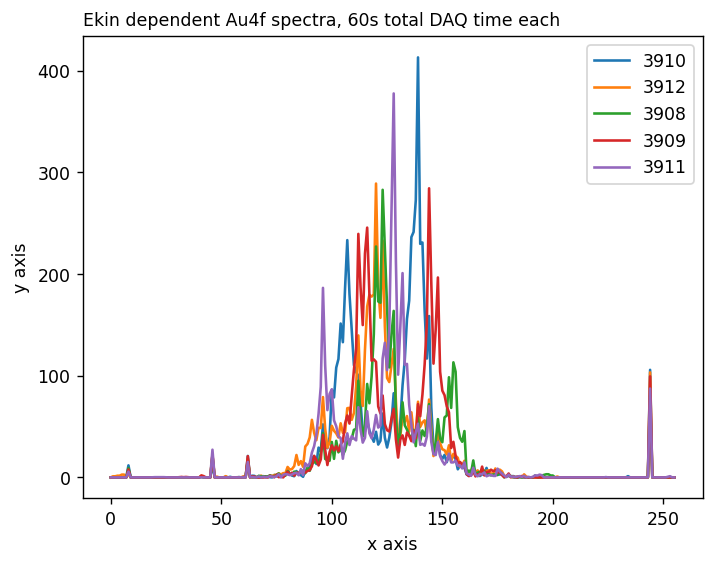

In [72]:
# 26 3910 | 27 3912 | 28 3908 | 29 3909 | 30 3911
IM_plt.plot_1D([spectrum26, spectrum27, spectrum28, spectrum29, spectrum30], 
               title = 'Ekin dependent Au4f spectra, 60s total DAQ time each', 
               legend = ['3910', '3912', '3908', '3909', '3911'], 
               dpi_plot=125)

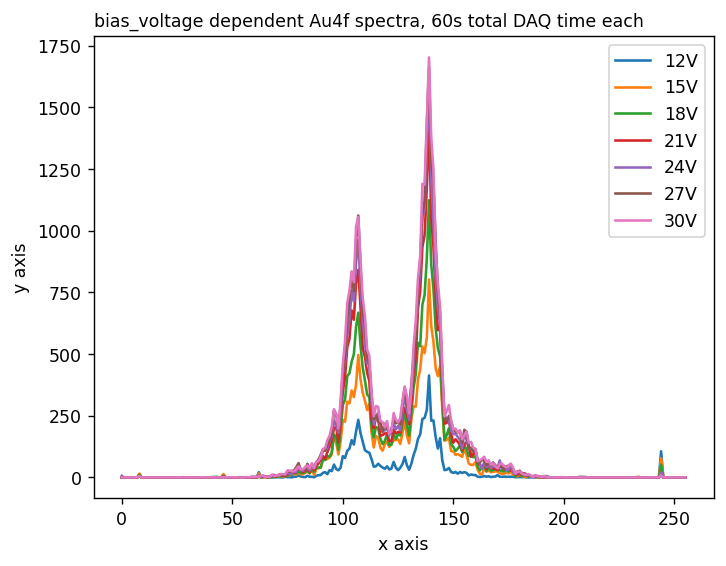

In [19]:
IM_plt.plot_1D([spectrum26, spectrum32, spectrum33, spectrum34, spectrum35, spectrum36, spectrum37], 
               title = 'bias_voltage dependent Au4f spectra, 60s total DAQ time each', 
               legend = ['12V', '15V', '18V', '21V', '24V', '27V', '30V'], 
               dpi_plot=125)

In [ ]:
#26: [12V] 6142 counts
#32: [15V] 17016 counts
#33: [18V] 22068 counts
#34: [21V] 27369 counts
#35: [24V] 30852 counts
#36: [27V] 33162 counts
#37: [30V] 34861 counts

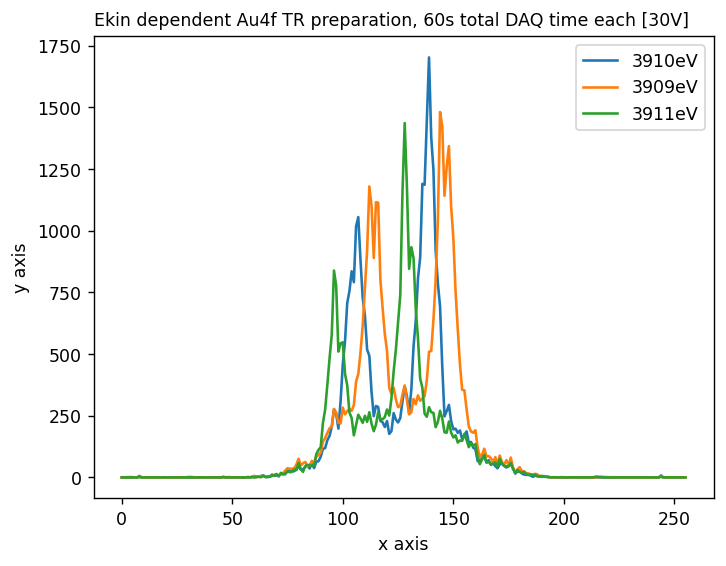

In [26]:
IM_plt.plot_1D([spectrum37, spectrum38, spectrum39], 
               title = 'Ekin dependent Au4f TR preparation, 60s total DAQ time each [30V]', 
               legend = ['3910eV', '3909eV', '3911eV'], 
               dpi_plot=125)